# Quickstart Example

Let’s consider a simple regression problem on diabetes data provided by Scikit-learn. We want to evaluate the uncertainty associated with the prediction using inductive (or split) conformal prediction.

## Data Loading and Processing

In [1]:
import numpy as np
from sklearn import datasets

random_seed = 42
np.random.seed(random_seed)

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
X_train = diabetes_X[:-100]
X_test = diabetes_X[-100:]

# Split the targets into training/testing sets
y_train = diabetes_y[:-100]
y_test = diabetes_y[-100:]

# Split fit and calibration data
X_fit, X_calib = X_train[:-100], X_train[-100:]
y_fit, y_calib = y_train[:-100], y_train[-100:]

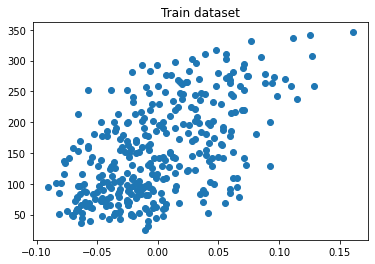

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(X_train, y_train)
plt.title("Train dataset")
plt.show()

## Model Definition

In [3]:
from sklearn import linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

## Quantification of uncertainty using conformal prediction

In the following, we show two ways of defining and using conformal prediction wrappers:
- A fast way based on the high-level API 
- A flexible way based of full customization of the prediction model, the residual computation and the fitting/calibration split plan   

For all the following experiments, the miscoverage level is set to 10%.

In [4]:
# Miscoverage target
alpha=.1

### High-level API

Here is an example of using Split CP from the high-level API.

In [5]:
from deel.puncc.regression import SplitCP
from deel.puncc.api.prediction import BasePredictor

# Wrap models in a mean/variance predictor
linear_predictor = BasePredictor(model=regr)
# The regression model is provided during split cp object instantiation
split_cp = SplitCP(linear_predictor) 
# The fit method trains the model and computes the residuals on the calibration set
split_cp.fit(X_fit, y_fit, X_calib, y_calib)
# The predict method infers prediction intervals with respect to the risk alpha
y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=alpha)

#### Results

Marginal coverage: 0.95
Average width: 211.38


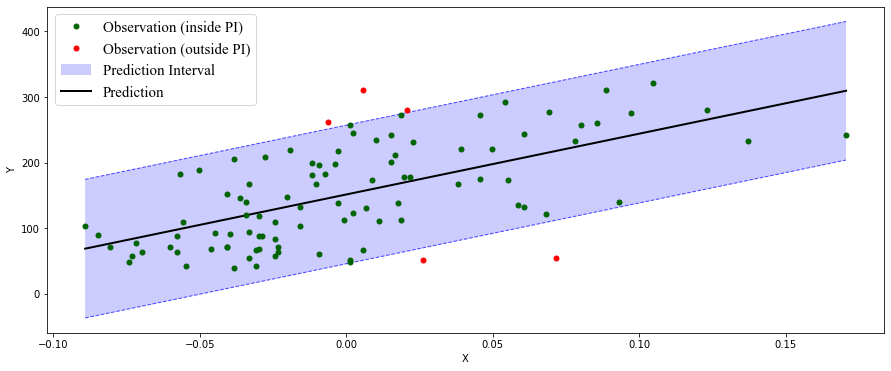

In [6]:
from deel.puncc import metrics
from deel.puncc.plotting import plot_prediction_intervals

coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)

print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

# Figure of the prediction bands
ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")


### Low-level API

We now define the **same split conformal prediction** procedure using the low-level API. Also, we showcase how flexible such approach is by tweaking some of its components.

#### Calibrator

The calibrator instance provides a way of estimating the nonconformity scores on the calibration set and how to compute the prediction sets. For the split conformal prediction procedure, the `BaseCalibrator` uses the mean absolute deviation as nonconformity score and and prediction set are built as constant intervals. These two functions are already provided in `deel.puncc.api.nonconformity_scores.mad` and `deel.puncc.api.prediction_sets.constant_interval`, respectively. Alternatively, one can define custom functions and pass them as arguments to the calibrator. 

In [7]:
from deel.puncc.api.calibration import BaseCalibrator
from deel.puncc.api import nonconformity_scores
from deel.puncc.api import prediction_sets

## Calibrator construction
my_calibrator = BaseCalibrator(nonconf_score_func=nonconformity_scores.mad,
                               pred_set_func=prediction_sets.constant_interval)

#### Splitter

In **split conformal prediction**, we can either use a deterministic or a random procedure to split the data into fit and calibration.
As we already separated the two subsets, we use the IdSplitter that wraps the data and produces iterables accordingly to **puncc**'s framework: 

In [8]:
from deel.puncc.api.splitting import IdSplitter

# Wrapper predetermined data schemes in the id splitter 
id_splitter = IdSplitter(X_fit, y_fit, X_calib, y_calib)

#### Conformalization

The split **conformal predictor** assembles the previously defined **predictor**, **calibrator** and **splitter** in a specific process to provide prediction intervals with a guaranteed coverage rate: 

In [9]:
from deel.puncc.api.conformalization import ConformalPredictor
from deel.puncc.api.splitting import IdSplitter

# Wrapper predetermined data schemes in the id splitter 
id_splitter = IdSplitter(X_fit, y_fit, X_calib, y_calib)
# Instanciate a conformal prediction object
split_cp = ConformalPredictor(predictor=linear_predictor, 
                              calibrator=my_calibrator, 
                              splitter=id_splitter,
                              train=True)
# Fit model and compute nonconformity scores
split_cp.fit(X_train, y_train)
# infer prediction interval w.r.t the level risk alpha
y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=alpha)

Marginal coverage: 0.95
Average width: 211.38


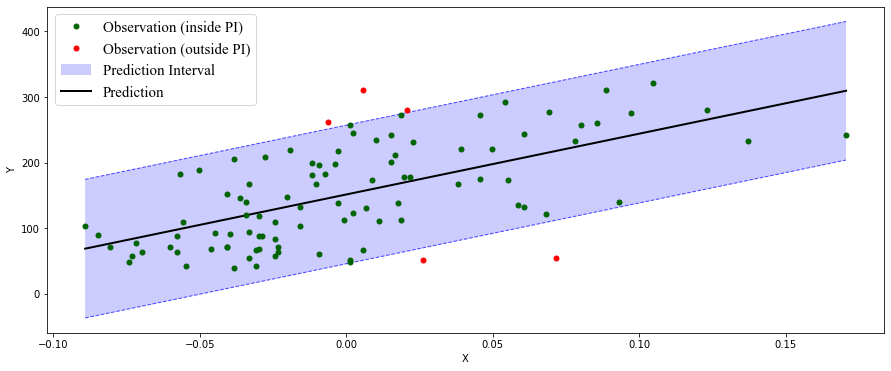

In [10]:
coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)

print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

# Figure of the prediction bands
ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")

As such, we obtain the same results as in the high-level API. Notice that we have a conservative prediction interval, because the obtained empirical coverage is larger than the target.

Now let's try to have a tighter enveloppe by modifying the split plan into a K-fold. This is simply done by changing the splitter argument in the `ConformalPredictor` constructor:

In [11]:
from deel.puncc.api.splitting import KFoldSplitter

# 20-fold data splitter
kfold_splitter = KFoldSplitter(K=20, random_state=random_seed)

# Only the splitter argument is changed from before
cv_cp = ConformalPredictor(predictor=linear_predictor, 
                           calibrator=my_calibrator, 
                           splitter=kfold_splitter,
                           train=True)

cv_cp.fit(X_train, y_train)

y_pred, y_pred_lower, y_pred_upper = cv_cp.predict(X_test, alpha=alpha)

Marginal coverage: 0.95
Average width: 208.97


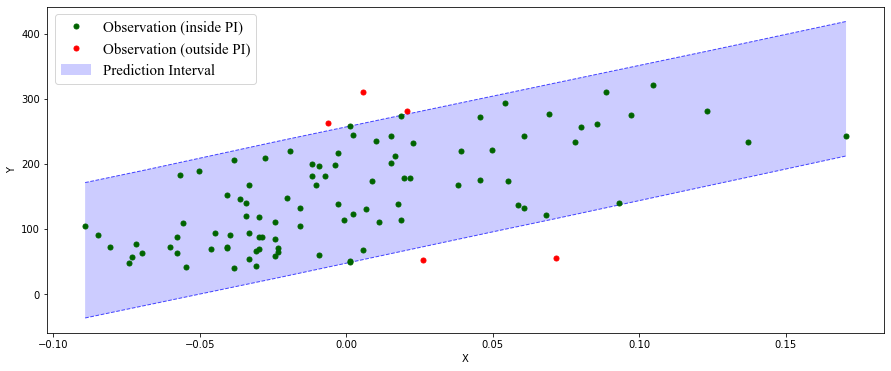

In [12]:
coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)

print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

# Figure of the prediction bands
ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")

For example, the `BaseCalibrator` below integrates custom nonconformity score (`my_ncf`) and prediction set (`my_psf`) functions:

Now, let's use a state of the art method called EnbPI. This method is specifically tailored for case where data are not exchangeable.

In [13]:
from deel.puncc.regression import EnbPI
from sklearn.ensemble import RandomForestRegressor

mu_rf = RandomForestRegressor(n_estimators=100, n_jobs=4, random_state=random_seed)
rf_predictor = BasePredictor(mu_rf)
enbpi = EnbPI(rf_predictor, B=30, agg_func_loo=np.mean)
enbpi.fit(X_train, y_train)
y_pred, y_pred_lower, y_pred_upper = enbpi.predict(X_test, alpha=alpha, y_true=y_test, s=None)

100%|██████████| 342/342 [00:00<00:00, 7969.53it/s]


 === step 1/2: fitting bootstrap estimators ...


100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


 === step 2/2: computing nonconformity scores ...


Marginal coverage: 0.91
Average width: 225.56


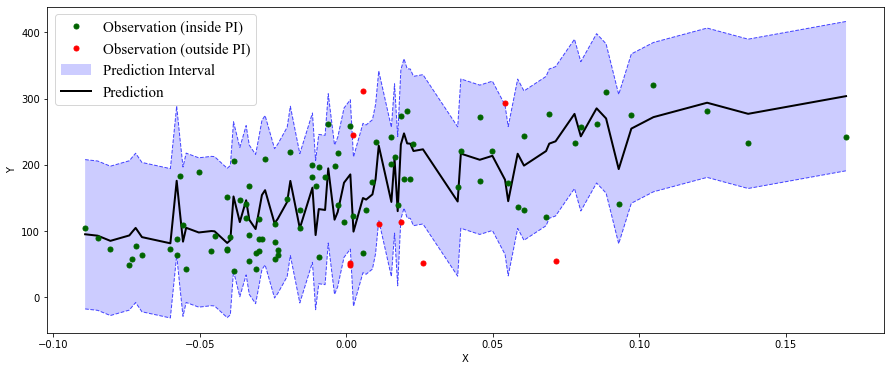

In [14]:
coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)

print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

# Figure of the prediction bands
ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")